# [LAB 11] 이원분산분석 연습문제



### #01. 준비작업
#### 패키지 참조

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt


# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova


# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

#### 그래프 초기화

In [48]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

## 문제 1.
poisons 데이터셋은 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터이다.
사용된 독극물 종류와 치료 유형에 유의미한 차이가 있는지 분석하라.

#### 데이터 가져오기

In [3]:
poisons = load_data('poisons')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {poisons.shape}")
print(f"열 개수: {poisons.shape[1]}")
print(f"행 개수: {poisons.shape[0]}")
print("\n===== 타입확인 =====")

print(poisons.info())
poisons.head()

[data] https://data.hossam.kr/data/lab10_/poisons.xlsx
[desc] 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터 (출처: 방송통신대학교 통계학 개론)

field    description
-------  ------------------
time     동물의 생존시간
poison   사용된 독극물 종류
treat    사용되는 치료 유형


===== 데이터 크기 확인 =====
데이터셋 크기: (360, 3)
열 개수: 3
행 개수: 360

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    360 non-null    float64
 1   poison  360 non-null    object 
 2   treat   360 non-null    object 
dtypes: float64(1), object(2)
memory usage: 8.6+ KB
None


,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1


In [8]:
poisons['treat'].unique()

array(['T1', 'T2', 'T3', 'T4'], dtype=object)

<시각화>
1) 독극물 종류별 치료물의 생존 시간 비교

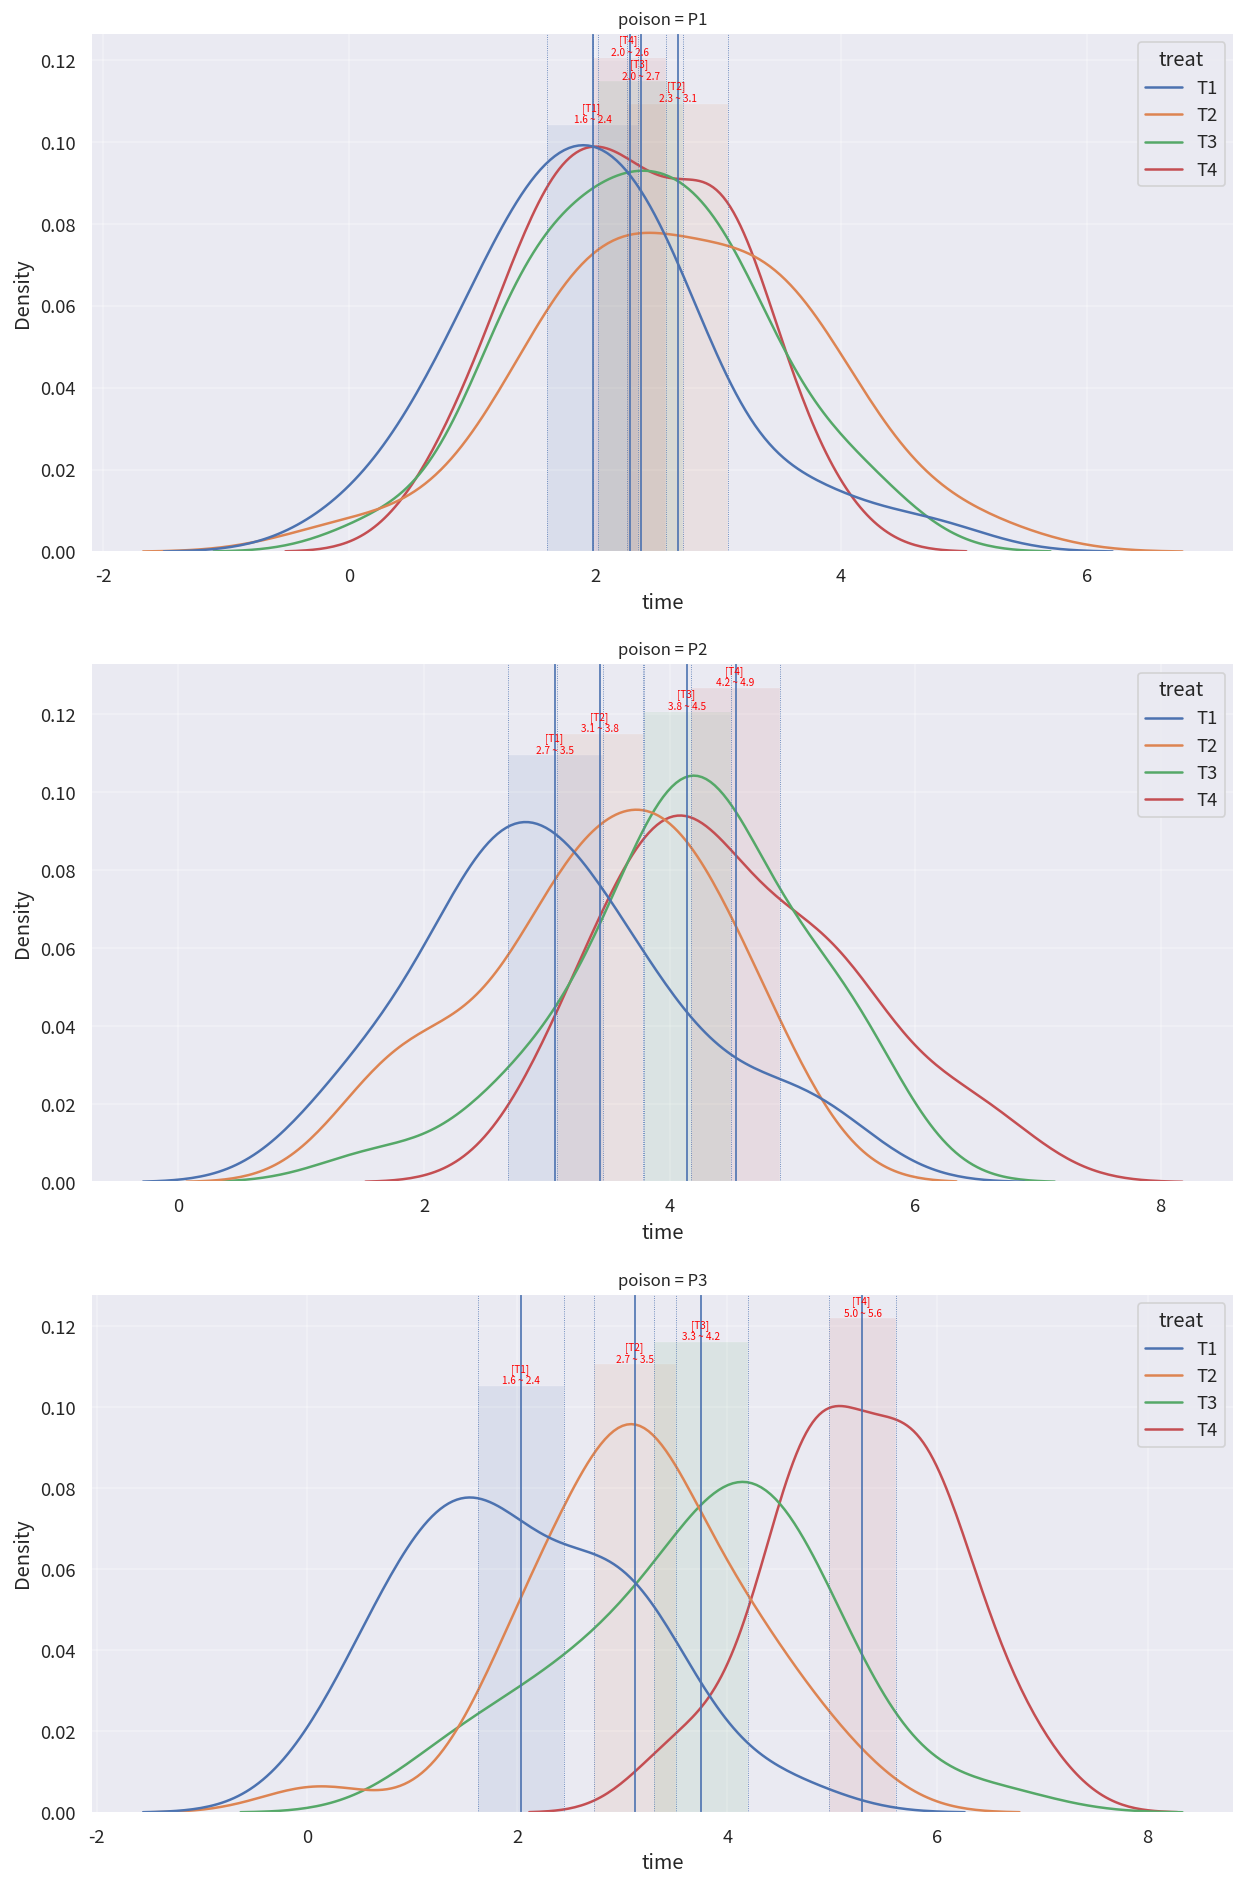

In [9]:
field = 'time'
group_field = 'poison'
hue_field = 'treat'

# 시각화 할 필드만 원본 데이터에서 추출
data = poisons[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count                  # 그래프 행 수
cols = 1 # 그래프 열 수
width_px  = 1280 * cols             # 그래프 가로 크기
height_px = 640* rows              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        
        # 신뢰구간
        max = temp_sub[field].max()                         # 최대값
        clevel = 0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준오차
        
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        
        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='-', linewidth=1)
        
        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] \n%0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

2) 치료물 종류별 각 독극물의 생존 시간 비교

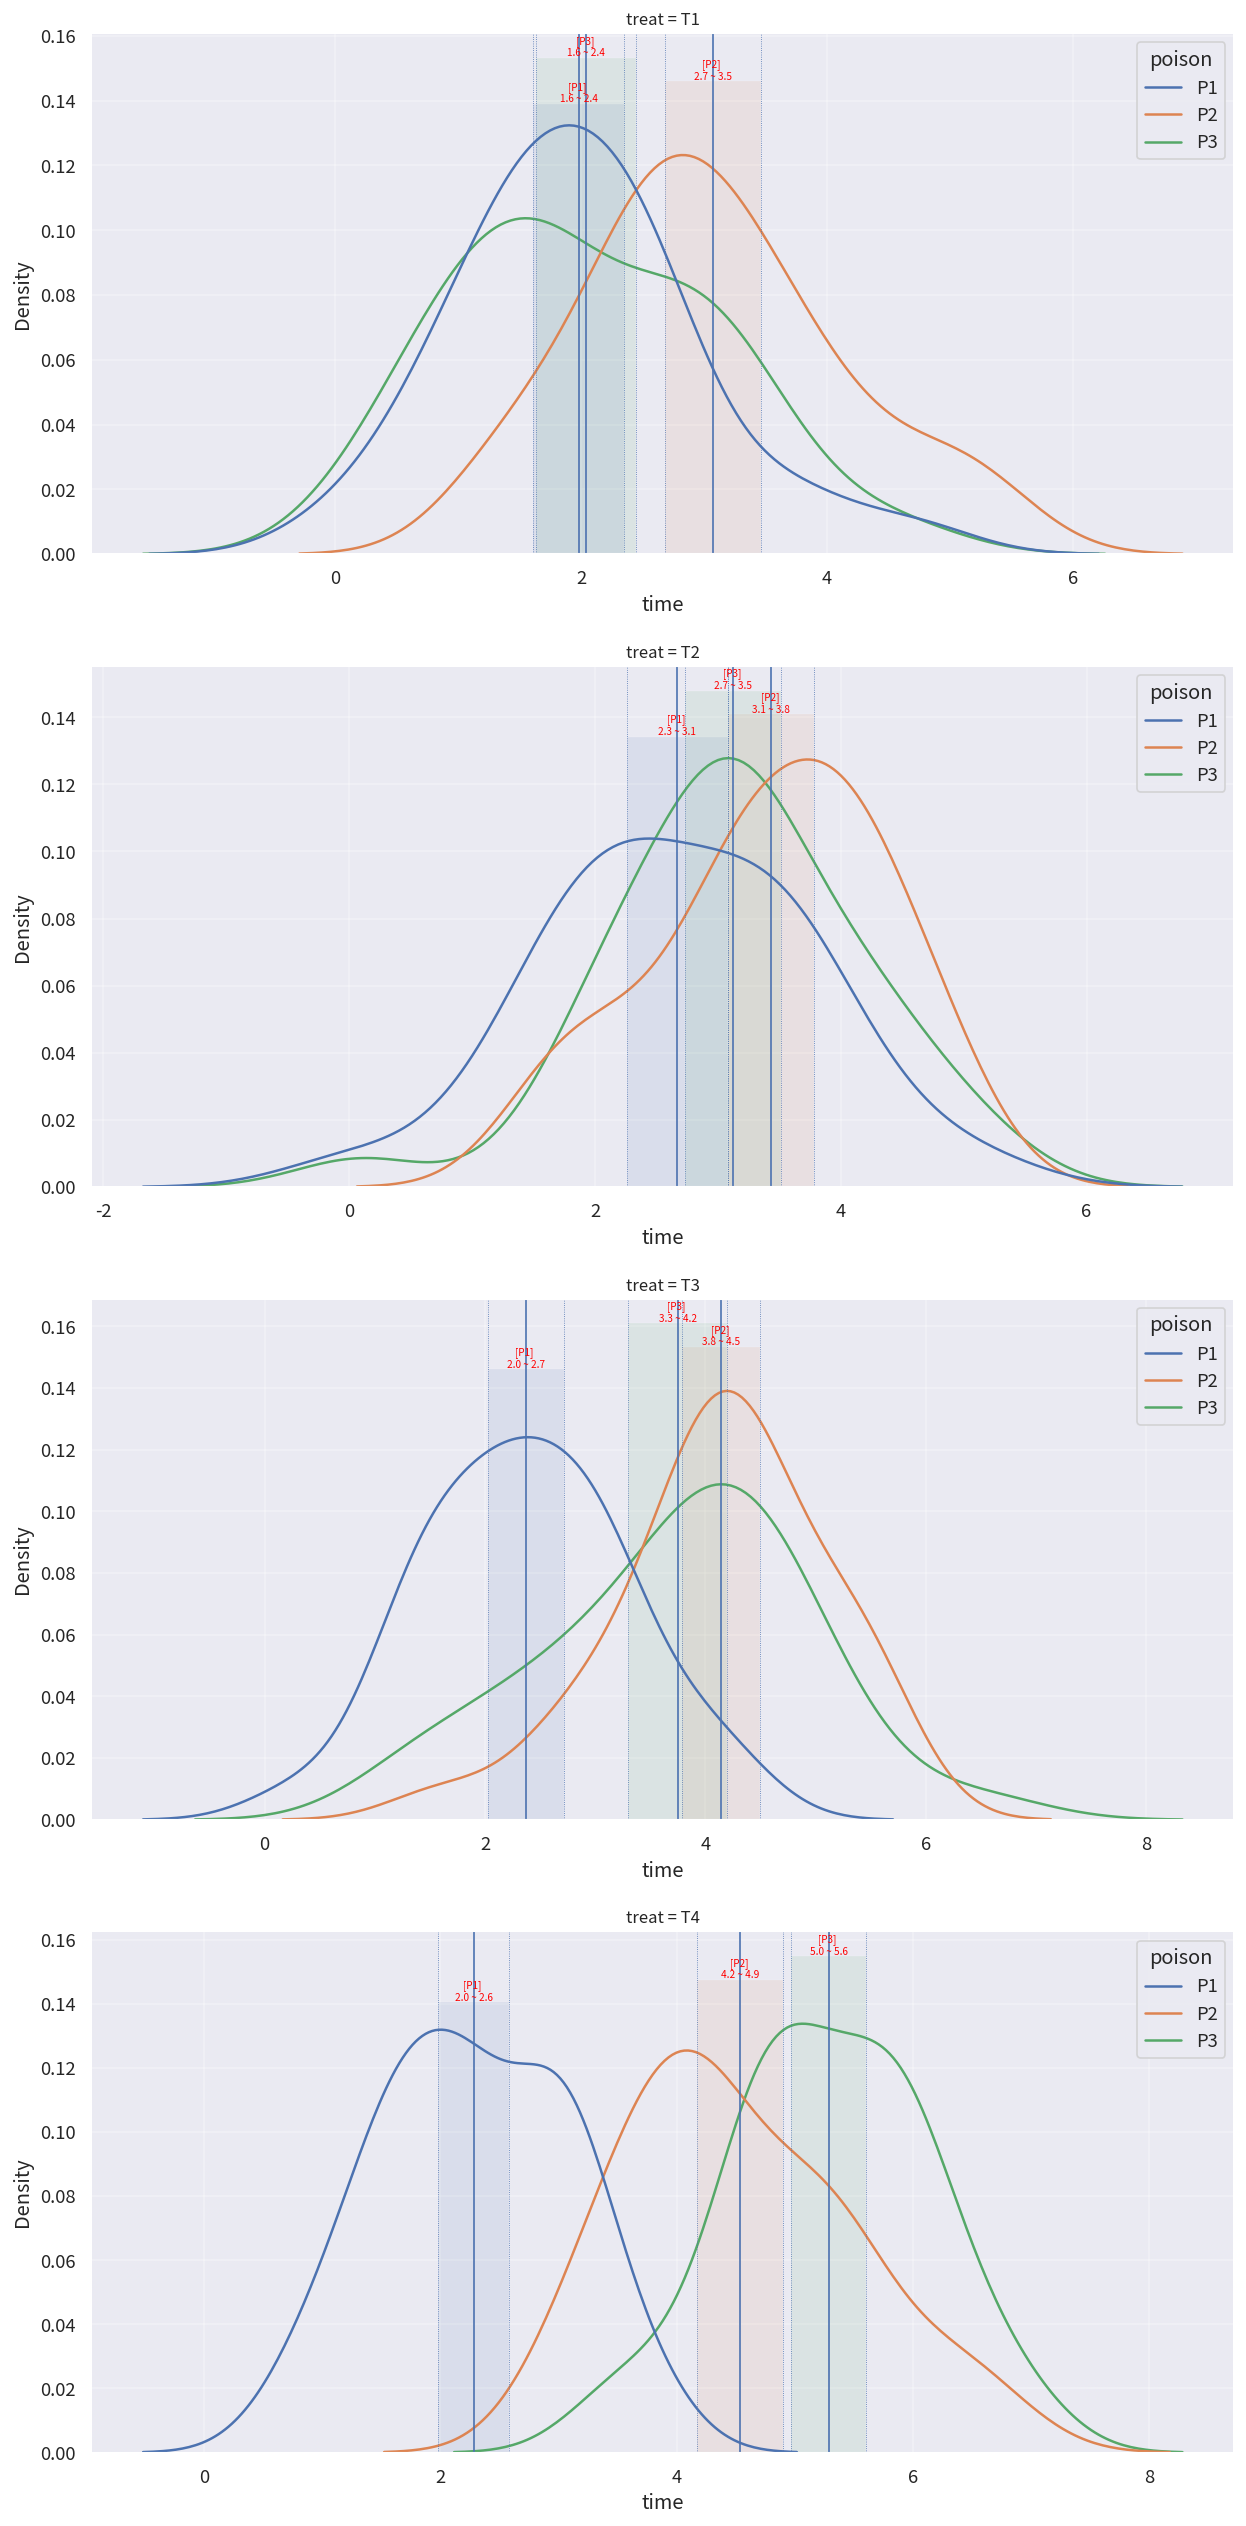

In [10]:
field = 'time'
group_field = 'treat'
hue_field = 'poison'

# 시각화 할 필드만 원본 데이터에서 추출
data = poisons[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count                  # 그래프 행 수
cols = 1 # 그래프 열 수
width_px  = 1280 * cols             # 그래프 가로 크기
height_px = 640* rows              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        
        # 신뢰구간
        max = temp_sub[field].max()                         # 최대값
        clevel = 0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준오차
        
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        
        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='-', linewidth=1)
        
        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] \n%0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

<가설검정의 검정 확인>

In [11]:
data = poisons.copy()
xname = ['poison', 'treat']
yname = 'time'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

equal_var = p > 0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"P1, T1",3.660816,0.160348,True
"P1, T2",0.266462,0.875263,True
"P1, T3",0.014374,0.992839,True
"P1, T4",1.476194,0.478023,True
"P2, T1",1.112279,0.573418,True
"P2, T2",1.509951,0.470022,True
"P2, T3",2.802084,0.246340,True
"P2, T4",1.662054,0.435602,True
"P3, T1",0.837473,0.657878,True


<분산분석 수행>

In [14]:
xname = ['treat' , 'poison']
yname = 'time'
data = poisons[xname + [yname]]

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)
display(pg_anova)
for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
      print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")

    else:
      print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,treat,131.260972,3,43.753657,43.891090,4.430485e-24,0.274506
1,poison,148.976389,2,74.488194,74.722166,1.002877e-27,0.300424
2,treat * poison,81.381611,6,13.563602,13.606206,6.938981e-14,0.190014
3,Residual,346.910333,348,0.996869,NaN,NaN,NaN


→ treat 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ poison 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ treat * poison 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


<사후검정>

In [16]:


# 데이터 준비
xname = ['treat', 'poison']
yname = 'time'
data = poisons[xname + [yname]]

# 1) 각 요인의 수준(집단) 개수 파악
levels = {}   
for factor in xname:                     
    level_count = data[factor].nunique() # 요인의 수준 수 계산
    levels[factor] = level_count         # 딕셔너리에 저장 ({'water': 2, 'sun': 3})

# 2) ANOVA 결과에서 p-value 추출
pvals = {}   
for index, row in pg_anova.iterrows():     
    source_name = row['Source']            
    p_value = row['p-unc']                 
    pvals[source_name] = p_value         # 딕셔너리에 저장 ({'water': 1.3e-20...})

# 3) 주효과에 대한 사후검정 판단 자동화
for factor in xname:
    print(f"\n[{factor}]")
    
    # 수준이 2개 이하이면 사후검정 불필요 (t-test와 동일하거나 평균 차이만 보면 됨)
    # 오타 수정: /= 2 -> <= 2
    if levels[factor] <= 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    # 해당 요인의 p-value 가져오기
    p_val = pvals.get(factor, None)
    
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue
    
    # 유의하지 않으면 사후검정 생략
    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue
    
    # 유의한 경우 사후검정 수행
    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")
    
    # 등분산 여부(equal_var)는 앞선 코드에서 정의되었다고 가정
    if equal_var:
        print("  · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print("  · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)
    
    display(hoc_df)

# 4) 상호작용 효과 판단 자동화
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")
    
    # 오타 수정: /= 0.05 -> < 0.05 (유의확률 기준)
    if p_val < 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[treat]
- 주효과 유의 (p=4.43e-24) → 사후검정 수행
  · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,T1,T2,2.363333,3.075556,-0.712222,0.189827,-3.751957,1.168920e-03,-0.639750
1,T1,T3,2.363333,3.421111,-1.057778,0.189827,-5.572330,2.971230e-07,-0.867932
2,T1,T4,2.363333,4.034444,-1.671111,0.189827,-8.803345,6.006307e-14,-1.220199
3,T2,T3,3.075556,3.421111,-0.345556,0.189827,-1.820373,2.654092e-01,-0.292572
4,T2,T4,3.075556,4.034444,-0.958889,0.189827,-5.051387,4.181336e-06,-0.717648
5,T3,T4,3.421111,4.034444,-0.613333,0.189827,-3.231015,7.343056e-03,-0.430346



[poison]
- 주효과 유의 (p=1e-27) → 사후검정 수행
  · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,P1,P2,2.325000,3.795833,-1.470833,0.161626,-9.100235,5.107026e-14,-1.388884
1,P1,P3,2.325000,3.550000,-1.225000,0.161626,-7.579233,9.585666e-13,-0.931693
2,P2,P3,3.795833,3.550000,0.245833,0.161626,1.521002,2.822579e-01,0.179210



[treat * poison] 상호작용 효과
- 상호작용 유의 (p=6.94e-14) → 단순주효과 분석 필요


<인사이트>

### #03.인사이트
#### 1.분석목적

본 분석은 동물의 생존 시간에 대해 사용된 독극물과 치료 유형이 어떤 영향을 미치는지를 평가하기 위해 이원분산분석을 수행하였다

(정규성 및 등분산성 확인 시 문제 없었음)

#### 2.분산분석 주요 결과

2-1 요인별 유의성 판단 (유의수준 a=0.o5 기준)

- 치료유형: p ≤ 0.05 → 유의함(대립가설 채택)  4.430485e-24
- 독극물: p ≤ 0.05 → 유의함(대립가설 채택)    1.002877e-27
- 치료유형 × 독극물: p ≤  0.05 → 유의함(대립가설 채택)   6.938981e-14

요약 : 선택한 독극물 혹은 치료 유형에 따라 생존 시간이 달라지는 경향이 있고, 독극물과 치료 유형의 결합 효과가 확인 되었다 


#### 3. 기술통계 및 집단별 평균 비교

● 치료유형 수준별 평균
치료유형 1: 2.363333
치료유형 2: 3.075556
치료유형 3: 3.421111
치료유형 4: 4.034444
→ 치료유형마다 평균 측정값이 다름

● 독극물 수준별 평균
독극물1 : 2.325000
독극물2 : 3.795833
독극물3 : 3.550000
→ 독극물마다 평균 측정값이 다름

● 상호작용 패턴 해석

모든 관측자가 태아 1·2·3을 측정할 때 **비슷한 순서(2번 > 1번 > 3번)**를 유지하며,
특정 태아에서만 관측자 차이가 갑자기 커지는 양상은 없음.

요약 해석

평균 패턴이 평행하게 나타나 상호작용 효과가 약함을 시사한다.

#### 4. 사후검정(Post-hoc) 결과

(유의수준 α = 0.05 기준 — ‘유의함 / 유의하지 않음’만 표시)

📌 치료방법 (주효과 유의 → 사후검정 실시)

1. T1 vs T2 → 유의함 (p = 0.001)
2. T1 vs T3 → 유의함 (p < 0.001)
3. T1 vs T4 → 유의함 (p < 0.001)
4. T2 vs T3 → 유의하지 않음 (p = 0.265)
5. T2 vs T4 → 유의함 (p < 0.001)
6. T3 vs T4 → 유의함 (p = 0.007)

요약: 치료법 2(T2)와 3(T3) 간에는 효과 차이가 발견되지 않았으나(유의하지 않음), 그 외의 모든 치료법 조합 간에는 뚜렷한 차이가 있습니다. 특히 T1은 다른 모든 치료법과 확연히 다릅니다.

📌 독극물 (주효과 유의 → 사후검정 실시)

1. P1 vs P2 → 유의함 (p < 0.001)
2. P1 vs P3 → 유의함 (p < 0.001)
3. P2 vs P3 → 유의하지 않음 (p = 0.282)

→ 독 1(P1)은 다른 독들과 확실히 다른 영향을 주지만, 독 2(P2)와 독 3(P3) 간에는 통계적인 차이가 없습니다.

📌 상호작용 유의함

6.94e-14 > 단순주효과 분석 필요

📝 요약 해석




#### 5. 최종 결론 요약
- 치료제마다 생순 시간의 편차가 존재하며 주효과가 유의함
- 독극물마다 생순 시간의 편차가 존재하며 주효과가 유의함
- 상호작용 효과는 유의했음

최종 한 문장 결론
: 동물의 생존 시간은 선택한 독극물과 치료제에 의해 유의하게 달라지지만, 두 요인의 상호 작용 효과는 존재한다


## 문제2
tomato 데이터 셋은 효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지에 대한 실험 결과이다.
분산분석을 하여 효소 함량에 따라 토마토 모종 성장에 차이가 나는지 검정하라.

#### 데이터 가져오기

In [17]:
tomato = load_data('tomato')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {tomato.shape}")
print(f"열 개수: {tomato.shape[1]}")
print(f"행 개수: {tomato.shape[0]}")
print("\n===== 타입확인 =====")

print(tomato.info())
tomato.head()

[data] https://data.hossam.kr/data/lab10_/tomato.xlsx
[desc] 효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지에 대한 실험 결과 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (90, 2)
열 개수: 2
행 개수: 90

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   효소함량    90 non-null     int64  
 1   모종성장    90 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.5 KB
None


,효소함량,모종성장
0,0,9.5
1,0,10.0
2,0,10.7
3,0,9.0
4,0,12.4


<데이터 분포>

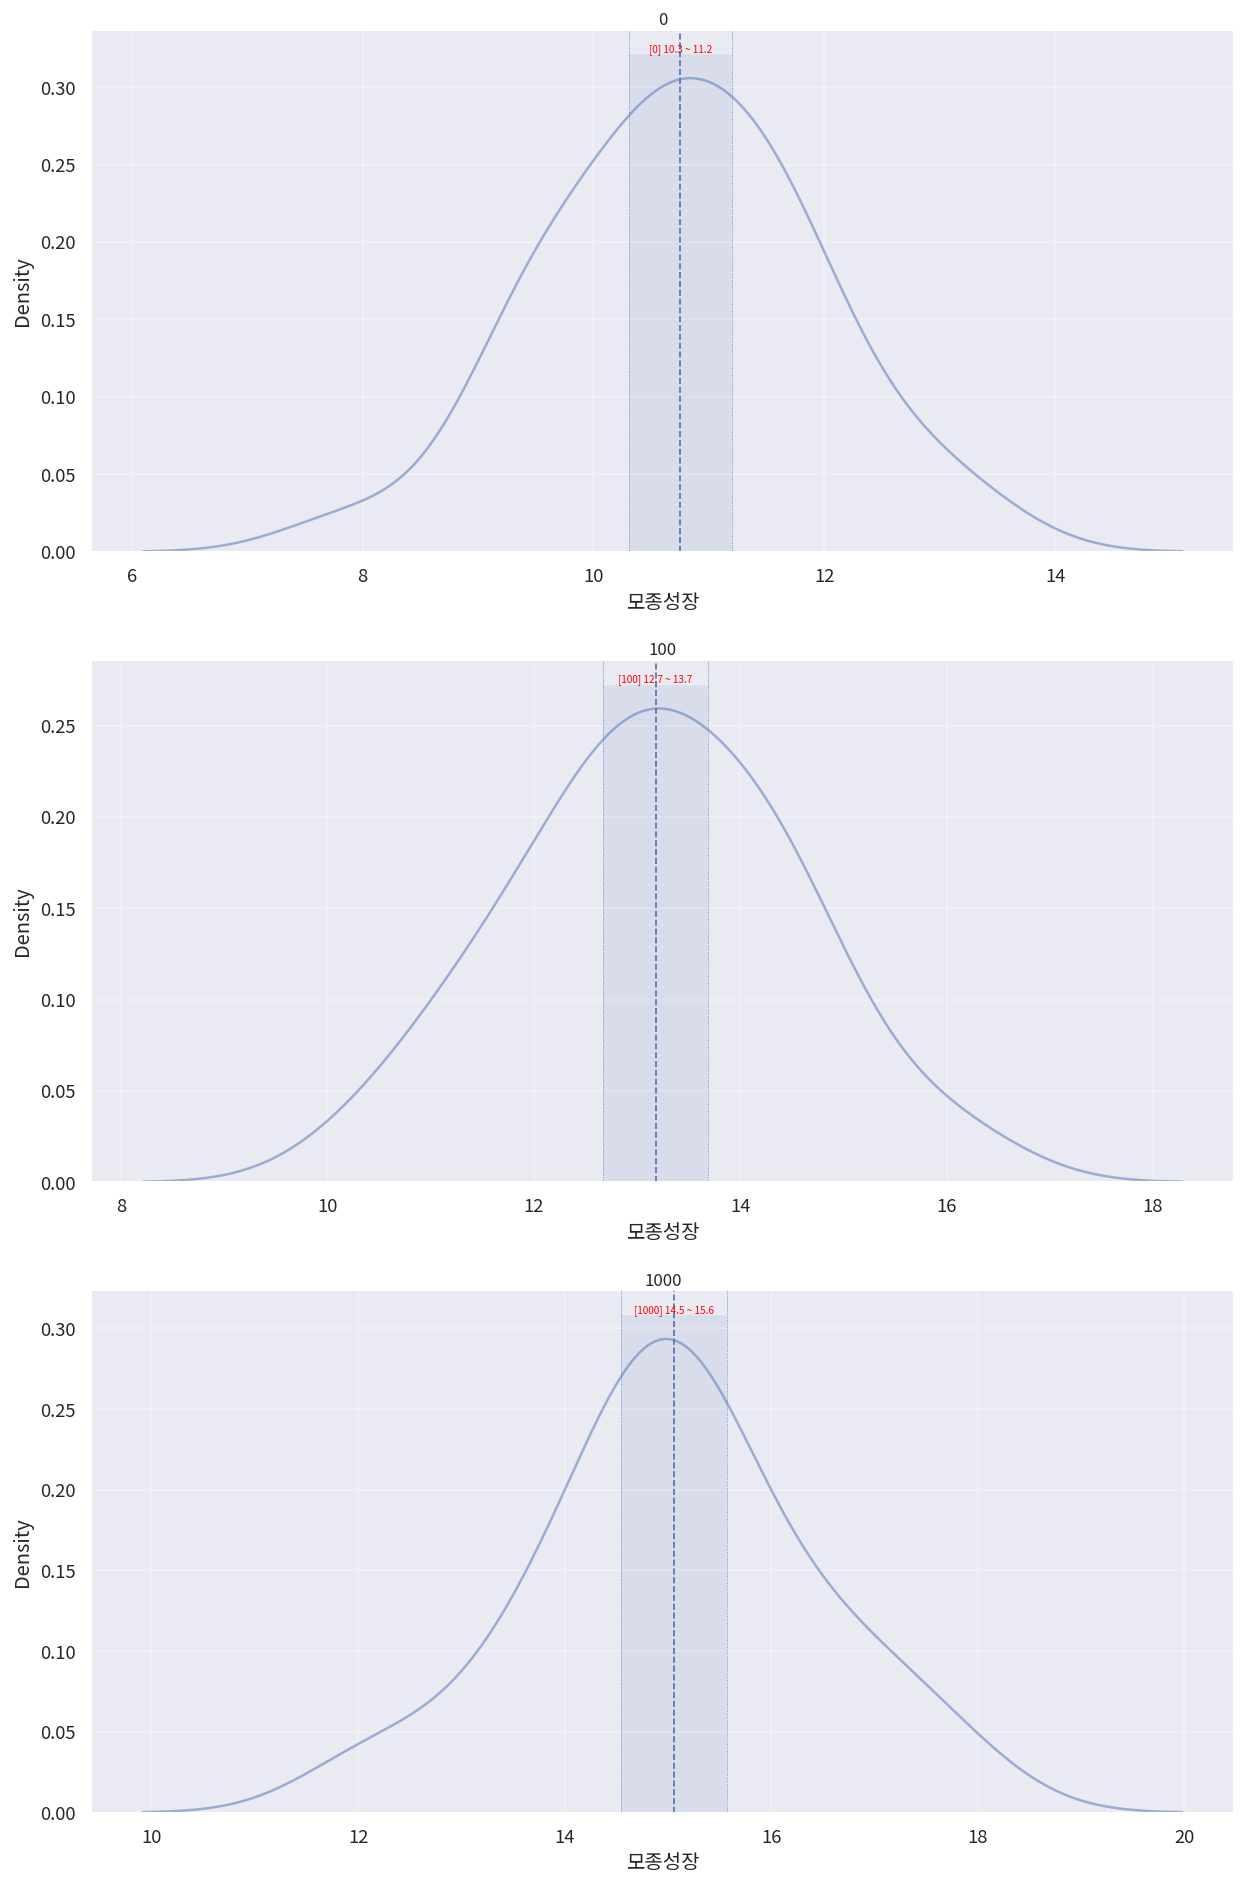

In [21]:
# 확인할 데이터 필드
field = '모종성장'

# 집단을 구분하는 필드(hue)
hue_field = '효소함량'

# 요일 종류 구하기
hue_values = tomato[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화
width_px  = 1280      # 그래프 가로 크기
height_px = 640 * 3   # 그래프 세로 크기
rows = 3              # 그래프 행 수
cols = 1              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):

    temp = tomato[tomato[hue_field] == v]
    #display(temp)

    # KDE Plot 그리기
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간
    max = temp[field].max()               # 최대값
    clevel = 0.95                         # 신뢰수준
    dof = len(temp[field]) - 1            # 자유도
    sp_mean = temp[field].mean()          # 표본평균
    sp_std = temp[field].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field]))   # 표본표준오차

    cmin, cmax = t.interval(
        clevel, dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between(
        (cmin, cmax), 0, ymax, alpha=0.1
    )
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax[i].text(
        x=(cmax - cmin)/2 + cmin,
        y=ymax,
        s=f"[{v}] {cmin:.1f} ~ {cmax:.1f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"}
    )

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


<정규성 등분산성 검정>

In [25]:
# 요일별 그룹 생성
groups = [(name, grp['모종성장']) for name, grp in tomato.groupby('효소함량')]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "field": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok


# 등분산성 검정 선택
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups])
else:
    test_name = "Levene"
    stat, p = levene(*[s.values for _, s in groups], center='median')

equal_var = p > 0.05

report.append({
    "field": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
0,0.237689,0.887946,True
100,0.000368,0.999816,True
1000,0.234748,0.889253,True
Bartlett,0.776052,0.678395,True


<pingouin 패키지 사용>

In [26]:
if equal_var :
  pg_anova = anova (data = tomato , dv='모종성장',between ='효소함량')

else :
  pg_anova = welch_anova(data = tomato , dv = '모종성장' , between ='효소함량')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,효소함량,2,87,81.094169,1.318657e-20,0.650866


In [28]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 81.094, p-value: 0.000, 대립가설 채택'

<사후검정>

In [29]:
if equal_var:
    print ('=== Tukey HSD ===')
    hoc_df = pairwise_tukey(data=tomato, dv='모종성장', between='효소함량')

else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(tomato, dv='모종성장', between='효소함량')
hoc_df


=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,100,10.753333,13.180000,-2.426667,0.338824,-7.162024,7.228520e-10,-1.867526
1,0,1000,10.753333,15.056667,-4.303333,0.338824,-12.700788,2.220446e-15,-3.315507
2,100,1000,13.180000,15.056667,-1.876667,0.338824,-5.538763,9.517362e-07,-1.350914


### #03.인사이트
#### 1.분석목적

본 분석은 효소함량 종류에 따라 모종 성장에어떤 영향을 미치는지를 평가하기 위해 일원분산분석을 수행하였다

(정규성 및 등분산성 확인 시 문제 없었음)

#### 2.분산분석 주요 결과

2-1 요인별 유의성 판단 (유의수준 a=0.o5 기준)

- 효소함량: p ≤ 0.05 → 유의함(대립가설 채택)  1.318657e-20


요약 : 효소함량 (0 / 100 / 1000) 에 따라 모종 평균 성장에 하나라도 다른 집단이 존재한다


#### 3. 기술통계 및 집단별 평균 비교

● 효소함량 수준별 평균
효소함량 0: 10.753333
효소함량 100: 13.180000
효소함량 1000: 15.056667

→ 효소함량마다 평균 측정값이 다름


#### 4. 사후검정(Post-hoc) 결과

(유의수준 α = 0.05 기준 — ‘유의함 / 유의하지 않음’만 표시)

📌 효소함량 (주효과 유의 → 사후검정 실시)

1. 0 vs 100 → 유의함 (p = 7.228520e-10)
2. 0 vs 1000 → 유의함 (p < 2.220446e-15)
3. 100 vs 1000 → 유의함 (p < 9.517362e-07)


요약: 효소함량 0 과 100 / 100 과 1000 / 0 과 1000 간에는 모종의 성장에 다른 효과가 있었던 것으로 확인 되었다 


📝 요약 해석




#### 5. 최종 결론 요약
- 효소 함량이 많을수록 유의미하게 모종의 성장에 좋은 영향을 준 것이 통게적으로 유의미 하게 확인되었다



## 문제3
edu 데이터 셋은 두 가지 교육방법을 비교하기 위하여 능력이 비슷한 고등학교 학생 22명을 추출하고,

 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육방법으로 교육시킨 후 치른 학기말 시험 성적을 조사한 자료이다.


이 자료를 이용하여 두 가지 교육방법에 대한 국어와 영어의 효과가 서로 다르다고 할 수 있는지검정하라. (분석 목적에 맞는 데이터 재배치 과정이 필요합니다.)

#### 데이터 가져오기

In [30]:
edu = load_data('edu')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {edu.shape}")
print(f"열 개수: {edu.shape[1]}")
print(f"행 개수: {edu.shape[0]}")
print("\n===== 타입확인 =====")

print(edu.info())
edu

[data] https://data.hossam.kr/data/lab10_/edu.xlsx
[desc] 두 가지 교육방법을 비교하기 위하여 능력이 비슷한 고등학교 학생 22명을 추출하고, 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육방법으로 교육시킨 후 치른 학기말 시험 성적을 조사한 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (22, 3)
열 개수: 3
행 개수: 22

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   교육방법    22 non-null     int64
 1   국어      22 non-null     int64
 2   영어      22 non-null     int64
dtypes: int64(3)
memory usage: 660.0 bytes
None


,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65
5,1,69,70
6,1,55,79
7,1,76,80
8,1,77,76
9,1,70,90


In [35]:
df = melt(edu, id_vars = '교육방법',value_vars =['국어','영어'],var_name = '과목',value_name = '점수')

df.head()

,교육방법,과목,점수
0,1,국어,65
1,1,국어,87
2,1,국어,73
3,1,국어,79
4,1,국어,81


<데이터 시각화>

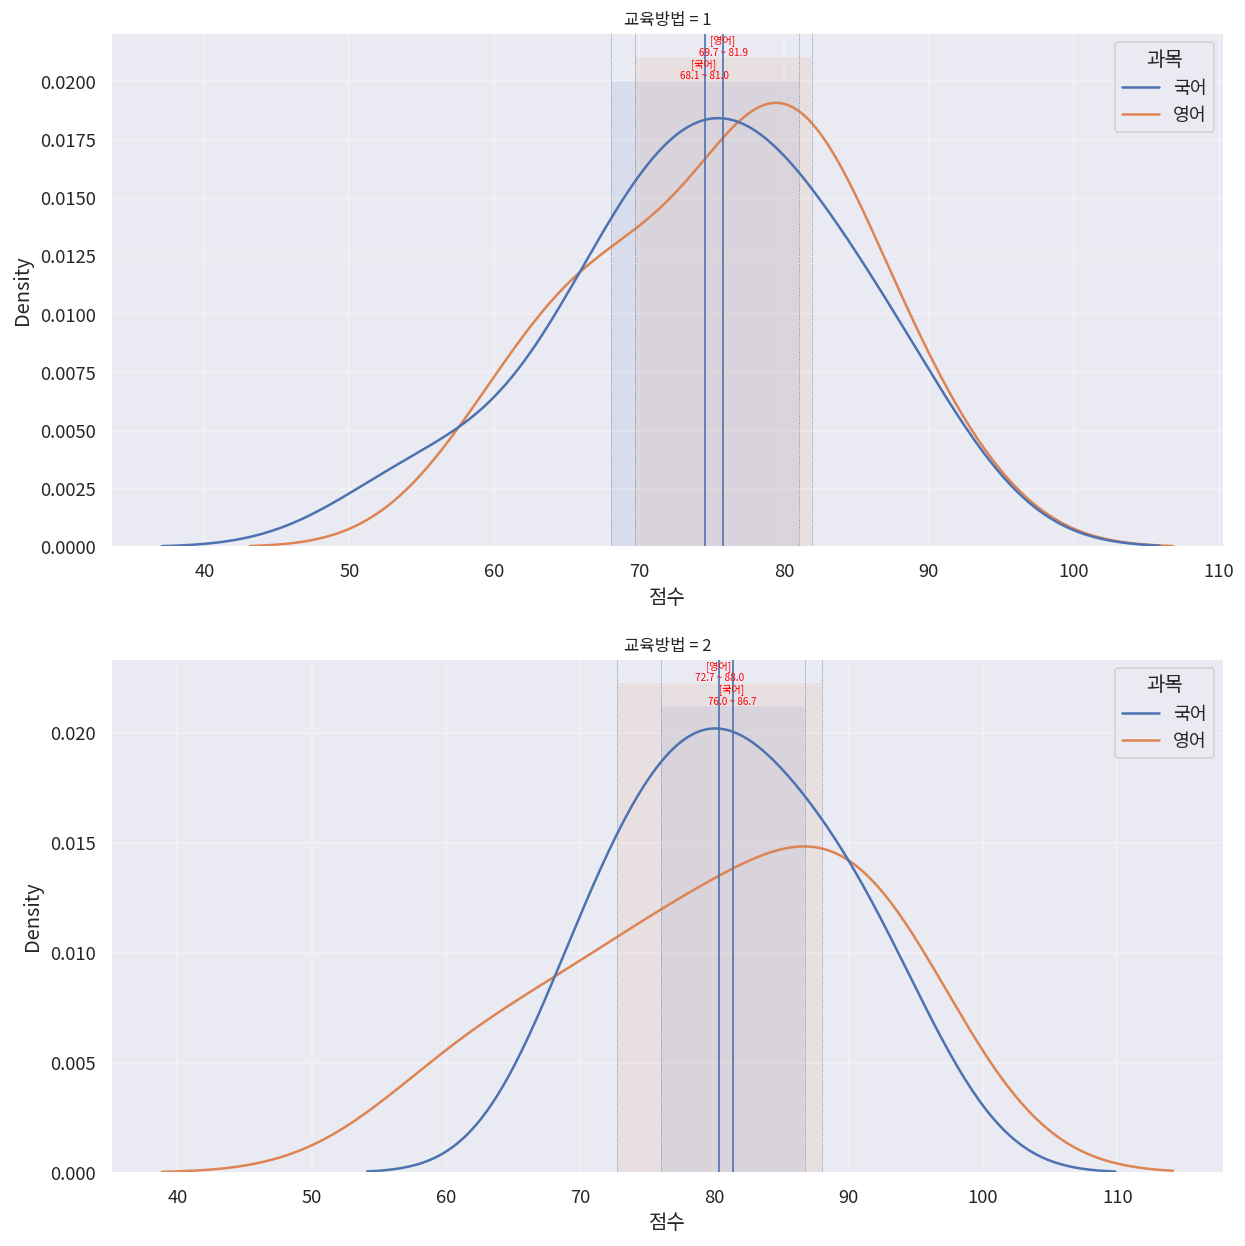

In [36]:
field = '점수'
group_field = '교육방법'
hue_field = '과목'

# 시각화 할 필드만 원본 데이터에서 추출
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count                  # 그래프 행 수
cols = 1 # 그래프 열 수
width_px  = 1280 * cols             # 그래프 가로 크기
height_px = 640* rows              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        
        # 신뢰구간
        max = temp_sub[field].max()                         # 최대값
        clevel = 0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준오차
        
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        
        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='-', linewidth=1)
        
        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] \n%0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

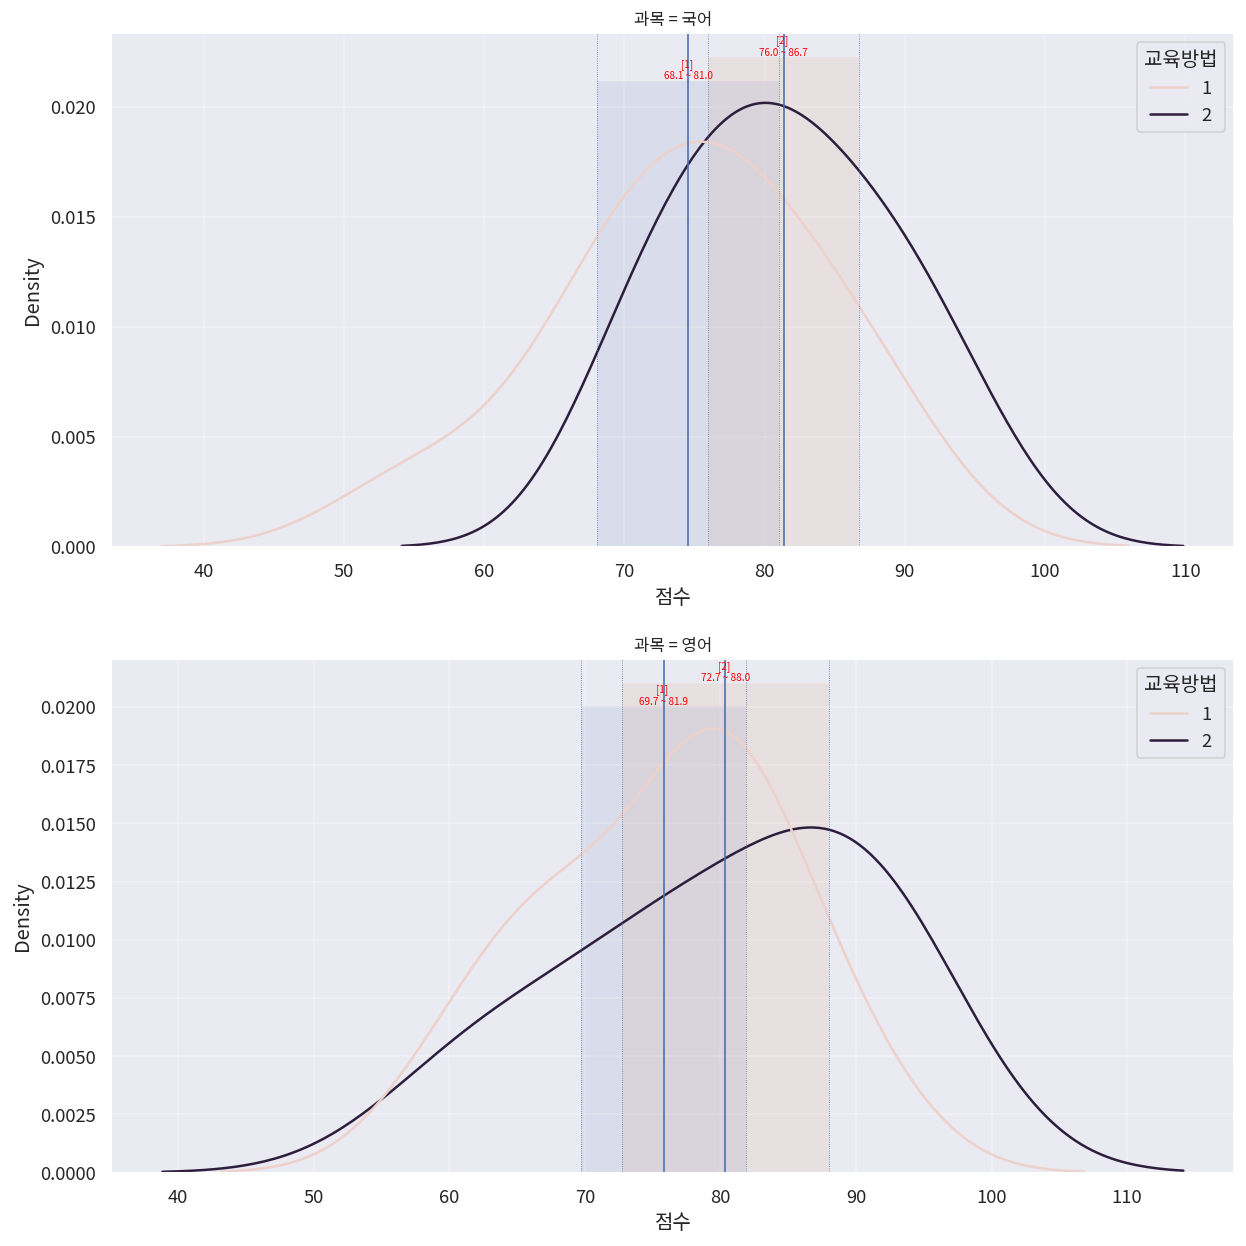

In [37]:
field = '점수'
group_field = '과목'
hue_field = '교육방법'

# 시각화 할 필드만 원본 데이터에서 추출
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count                  # 그래프 행 수
cols = 1 # 그래프 열 수
width_px  = 1280 * cols             # 그래프 가로 크기
height_px = 640* rows              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        
        # 신뢰구간
        max = temp_sub[field].max()                         # 최대값
        clevel = 0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준오차
        
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        
        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='-', linewidth=1)
        
        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] \n%0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

<가설검정의 가정 확인>

In [39]:
data = df.copy()
xname = ['과목', '교육방법']
yname = '점수'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

equal_var = p > 0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"국어, 1",0.911351,0.634020,True
"국어, 2",0.299661,0.860854,True
"영어, 1",0.389198,0.823165,True
"영어, 2",1.094669,0.578490,True
Bartlett,2.871293,0.411898,True


<분산분석 수행>

In [40]:
xname = ['과목' , '교육방법']
yname = '점수'
data = df[xname + [yname]]

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)
display(pg_anova)
for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
      print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")

    else:
      print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,과목,0.204545,1,0.204545,0.002215,0.962695,0.000055
1,교육방법,355.113636,1,355.113636,3.845870,0.056857,0.087713
2,과목 * 교육방법,14.204545,1,14.204545,0.153835,0.696979,0.003831
3,Residual,3693.454545,40,92.336364,NaN,NaN,NaN


→ 과목 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ 교육방법 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ 과목 * 교육방법 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


### #03.인사이트
#### 1.분석목적
본 분석은 두 가지 교육방법이 각 과목 (국어와 영어) 성적에 어떤 영향을 미치는지 평가하기 위해 이원분산분석을 수행하였다 


#### 2.분산분석 주요 결과

2-1 요인별 유의성 판단 (유의수준 a=0.o5 기준)

- 과목: p > 0.05 → 유의하지 않음(귀무가설 채택)
- 교육방법: p > 0.05 → 유의하지 않음(귀무가설 채택)
- 과목 × 교육방법: p > 0.05 → 유의하지 않음(귀무가설 채택)

요약 : 교육방법은 각 과목별 성적에 차이를 발생시키는 요인이 아니였다 

#